In [6]:
#Imports
import nilearn 
import pandas as pd
import numpy as np 
import nibabel as nib
import glob
import matplotlib.pyplot as plt

from nilearn import plotting, image
from nilearn.glm.first_level import FirstLevelModel
from nilearn.glm.first_level import compute_regressor
from nilearn.glm.first_level import make_first_level_design_matrix

from nilearn.plotting import plot_design_matrix

# Data path
analysis_folder='/project/4180000.19/multirat_stim/rabies/preprocess'
template_path ='/groupshare/traaffneu/preclinimg/templates/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Template.nii'
metadata_path ='/home/traaffneu/margal/code/multirat_se/script/table/metadata_stand.tsv'
mask = '/groupshare/traaffneu/preclinimg/templates/SIGMA_Wistar_Rat_Brain_TemplatesAndAtlases_Version1.1/SIGMA_Rat_Anatomical_Imaging/SIGMA_Rat_Anatomical_InVivo_Template/SIGMA_InVivo_Brain_Mask.nii'

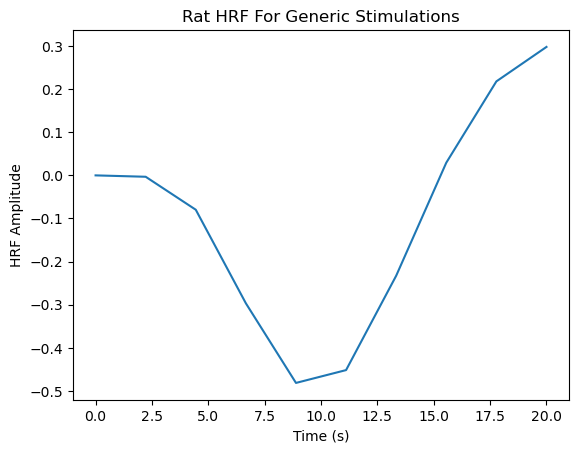

array([-0.        , -0.00321102, -0.07968843, -0.29672872, -0.48136245,
       -0.45159467, -0.23276135,  0.02940662,  0.2180086 ,  0.29793142])

In [7]:
# -- Generic Rat HRF 

# --- Generic rat HRF: stim >5sec --- 

    #Rref
#Matlab script H. Lambert (2019)        
#https://app.codecov.io/gh/nilearn/nilearn/pull/2942/blob/nilearn/glm/first_level/hemodynamic_models.py

#Evaluating the difference of two gamma probability density functions (PDFs)
# duration : stimulation duration in seconds
# tr : in seconds
# h1, h2, l1, and l2 : define the shape and scale parameters
# V = ratio parameter 

from scipy.stats import gamma

def rat_hrf_generic(tr, duration, oversampling=1, onset=0.0):
    dt = tr / oversampling
    time_length = duration + onset
    time_stamps = np.linspace(0, time_length, np.rint(time_length / dt).astype(int))
    time_stamps -= onset
     
    # Parameters of the gamma function
    h1 = 3.7
    h2 = 4.45
    l1 = 0.5
    l2 = 0.5
    V = 1.5

    response_function = (gamma.pdf(time_stamps, h1 / l1, scale=1 / l1) -
                         gamma.pdf(time_stamps, h2 / l2, scale=1 / l2)) / V
    
    response_function /= response_function.sum()
    response_function *= -1

    plt.plot(time_stamps, response_function)
    plt.xlabel('Time (s)')
    plt.ylabel('HRF Amplitude')
    plt.title('Rat HRF For Generic Stimulations')
    plt.show()

    return response_function

#def generic_time_derivative(tr, duration, oversampling=1, onset=0.0):
 #   do = 0.1
 #   first = rat_hrf_generic(tr, duration, oversampling, onset)
 #   second = rat_hrf_generic(tr, duration, oversampling, onset + do)
 #   drf = (first - second) / do
 #   print(first)
 #   print(second)
 #   print(onset + do)

 #  return drf
    
rat_hrf_generic(2.0, 20)
#generic_time_derivative(2.0, 20)

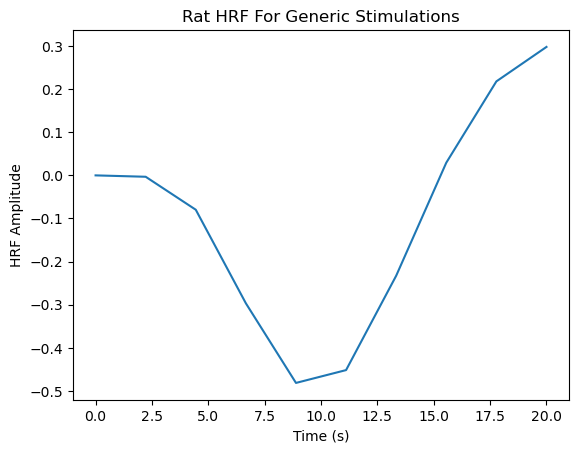

([array([-0.        , -0.00321102, -0.07968843, -0.29672872, -0.48136245,
       -0.45159467, -0.23276135,  0.02940662,  0.2180086 ,  0.29793142])], 'Rat HRF', ['main'])
[array([-0.        , -0.00321102, -0.07968843, -0.29672872, -0.48136245,
       -0.45159467, -0.23276135,  0.02940662,  0.2180086 ,  0.29793142])]


In [9]:
# Define response function models

hrf_models = [("spm + derivative + dispersion", "SPM HRF", None),
             ("glover + derivative + dispersion", "Glover HRF", None),
             ([rat_hrf_generic], "Rat HRF", ["main"]),]
                       
selected_model = hrf_models[2]                     # select a  model
hrf_model, model_title, labels = selected_model    # Unpack the selected model


print(selected_model)
print(hrf_model)

In [10]:
# Compute regressors 

tr = 2.0
onset = 0.0
duration = 20
onsets = [60, 140, 220]
durations = [20, 20, 20]
trial_type = [1, 1, 1]
exp_condition = np.array((onsets, durations, trial_type))

frame_times = np.linspace(0, duration, 61) 
oversampling=1

signal, _labels = compute_regressor(exp_condition=exp_condition,
                                    hrf_model=hrf_model,
                                    frame_times=frame_times,
                                    con_id="main",
                                    oversampling=oversampling)


print(signal)
print(_labels)


ValueError: "[array([-0.        , -0.00321102, -0.07968843, -0.29672872, -0.48136245,
       -0.45159467, -0.23276135,  0.02940662,  0.2180086 ,  0.29793142])]" is not a known hrf model. Use either a custom model or one of ['spm', 'spm + derivative', 'spm + derivative + dispersion', 'fir', 'glover', 'glover + derivative', 'glover + derivative + dispersion', None]

In [14]:
# Example from nilearn : https://nilearn.github.io/dev/auto_examples/04_glm_first_level/plot_hrf.html

from scipy.stats import gamma

import numpy as np

time_length = 30.0
oversampling = 16
frame_times = np.linspace(0, time_length, 61)
onset, amplitude, duration = 0.0, 1.0, 1.0
exp_condition = np.array((onset, duration, amplitude)).reshape(3, 1)

from scipy.stats import gamma


def mion_response_function(tr, oversampling=16, onset=0.0):
    """Implement the MION response function model.

    Parameters
    ----------
    tr: float
        scan repeat time, in seconds
    oversampling: int, optional
        temporal oversampling factor
    onset: float, optional
        hrf onset time, in seconds

    Returns
    -------
    response_function: array of shape(length / tr * oversampling, dtype=float)
        response_function sampling on the oversampled time grid
    """
    dt = tr / oversampling
    time_stamps = np.linspace(
        0, time_length, np.rint(time_length / dt).astype(int)
    )
    time_stamps -= onset

    # parameters of the gamma function
    delay = 1.55
    dispersion = 5.5

    response_function = gamma.pdf(time_stamps, delay, loc=0, scale=dispersion)
    response_function /= response_function.sum()
    response_function *= -1

    return response_function


def mion_time_derivative(tr, oversampling=16.0):
    """Implement the MION time derivative response function model.

    Parameters
    ----------
    tr: float
        scan repeat time, in seconds
    oversampling: int, optional
        temporal oversampling factor, optional

    Returns
    -------
    drf: array of shape(time_length / tr * oversampling, dtype=float)
        derived_response_function sampling on the provided grid
    """
    do = 0.1
    drf = (
        mion_response_function(tr, oversampling)
        - mion_response_function(tr, oversampling, do)
    ) / do

    return drf

# Define models 
rf_models = [
    ("spm + derivative + dispersion", "SPM HRF", None),
    ("glover + derivative + dispersion", "Glover HRF", None),
    (
        [mion_response_function, mion_time_derivative],
        "Mion RF + derivative",
        ["main", "main_derivative"],
    ),
]


for i, (rf_model, model_title, labels) in enumerate(rf_models):
    # compute signal of interest by convolution
    signal, _labels = compute_regressor(
        exp_condition=exp_condition,
        hrf_model=rf_model,
        frame_times=frame_times,
        con_id="main",
        oversampling=oversampling)

print(signal)
print(_labels)

[[ 0.          0.        ]
 [-0.01768077 -0.04840358]
 [-0.04800854 -0.06603228]
 [-0.0669797  -0.02730314]
 [-0.07689096 -0.01499442]
 [-0.08240275 -0.00784127]
 [-0.08513652 -0.00312105]
 [-0.08597171  0.00016059]
 [-0.0854635   0.0024946 ]
 [-0.08399151  0.00416458]
 [-0.08182808  0.00535099]
 [-0.0791746   0.00617644]
 [-0.07618304  0.00672806]
 [-0.07296951  0.00706993]
 [-0.06962336  0.00725027]
 [-0.06621362  0.00730609]
 [-0.06279359  0.00726617]
 [-0.05940422  0.00715311]
 [-0.05607675  0.00698481]
 [-0.0528347   0.0067755 ]
 [-0.04969542  0.00653655]
 [-0.04667132  0.00627703]
 [-0.04377088  0.00600421]
 [-0.04099943  0.00572387]
 [-0.03835975  0.00544061]
 [-0.03585267  0.00515805]
 [-0.03347742  0.00487905]
 [-0.03123198  0.0046058 ]
 [-0.02911343  0.00433998]
 [-0.0271181   0.00408283]
 [-0.02524178  0.00383525]
 [-0.02347991  0.00359787]
 [-0.02182766  0.00337105]
 [-0.02028006  0.00315499]
 [-0.01883205  0.00294975]
 [-0.0174786   0.00275524]
 [-0.0162147   0.0025713 ]
 

index: 0
subj: 200100
TR: 2.0
n stim: 3
stim duration: 20


/scratch/margal/49273008.dccn-l029.dccn.nl/ipykernel_47315/532475992.py:31: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  exp_condition = np.array((onsets, durations, trial_type))


Contrasts:  [1. 0. 0. 0. 0.]


/home/traaffneu/margal/.conda/envs/MultiRatStim/lib/python3.9/site-packages/nilearn/_utils/glm.py:335: RuntimeWarning: divide by zero encountered in divide
  return np.where(X <= 0, 0, 1. / X)


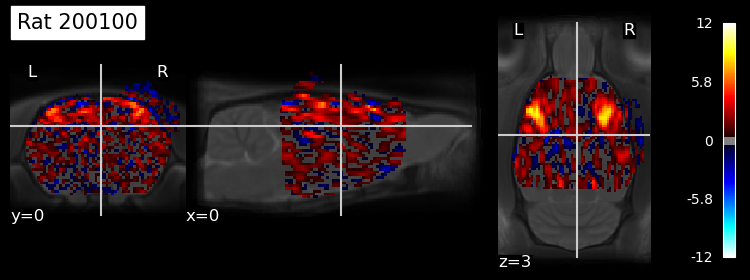

In [33]:
# ---------- FIRST LEVEL ANALYSIS ------------
# ---------------- Rat HRF -------------------

df = pd.read_csv(metadata_path, sep='\t')
df = df.loc[(df['exclude'] != 'yes')]

for index in range(0, 1):
    
    subj_num=str(df.iloc[index]['rat.sub'])[:-2]
    print('index:', index)
    print('subj:', subj_num)
    
    subject_path = glob.glob(analysis_folder + "/sub-0{}_ses-1/bold_datasink/commonspace_bold/*/*/*.nii.gz".format(subj_num, subj_num, subj_num))[0]
    func_img = nib.load(subject_path) 
    
     # --- Events regressor --- 
    
    n_scans = func_img.shape[3]   
    tr = (df.iloc[index]['func.TR']) 
    n_tr = np.count_nonzero((np.matrix(df.iloc[index]['func.sensory.onset'])))   #count number of stimulation, number of onset
    frame_times = np.arange(n_scans) * tr 
    
    onset_metadata = np.matrix(df.iloc[index]['func.sensory.onset']).A[0]  # Get onsets from metadata file
    scan_start_times = frame_times[:n_tr]                                  # Get the start times of each scan
    onsets = onset_metadata - scan_start_times                             # Subtract the start time of each scan

    durations = np.matrix(df.iloc[index]['func.sensory.duration']).A[0]
    trial_type = np.ones_like(onset)
    
    events = pd.DataFrame({'trial_type': trial_type,'onset': onsets,'duration': durations})
    exp_condition = np.array((onsets, durations, trial_type))
    
    # --- Specify the rat hrf --- 
    
    duration_1_stim = int(df.iloc[index]['func.sensory.duration'].split(',')[0].strip())
    
    print('TR:', tr)
    print('n stim:', n_tr)
    print('stim duration:', duration_1_stim)

    #hrf_regressor = compute_regressor(exp_condition, rat_hrf_generic(duration, tr), frame_times)

    
    # --- Compute design matrix --- 
    
    design_matrix = make_first_level_design_matrix(frame_times=frame_times, 
                                                   events=events, 
                                                   #add_regs=hrf_regressor, 
                                                   #add_reg_names=motion_names, 
                                                   drift_model="polynomial", 
                                                   drift_order=3, 
                                                   hrf_model='glover',
                                                   high_pass=0.01)


    # --- Fitting a first-level model ----  
    
    fmri_glm = FirstLevelModel(t_r=tr,
                               drift_model='polynomial',
                               signal_scaling=False,
                               minimize_memory=False)
    
    fmri_glm = fmri_glm.fit(subject_path, design_matrices=design_matrix)

    residuals = fmri_glm.residuals[0]
    predicted_timeseries = fmri_glm.predicted[0]
    
    # -- Coompute contrasts ---
    
    n_columns = design_matrix.shape[1]
    contrast_val = np.hstack(([1], np.zeros(n_columns - 1)))
    print('Contrasts: ', contrast_val)

    statistical_map = fmri_glm.compute_contrast(contrast_val, output_type='all')
    
    #-- Plot and save as nifti file ---
    
    plot_stat = plotting.plot_stat_map(statistical_map['z_score'], 
                                       bg_img = template_path, 
                                       threshold = 0.5, 
                                       title = 'Rat {}'.format(subj_num))
    

In [54]:
#frame_times = np.arange(n_scans) * tr 
frame_times = np.linspace(0, 2, 150) 
print(frame_times)


[0.         0.01342282 0.02684564 0.04026846 0.05369128 0.06711409
 0.08053691 0.09395973 0.10738255 0.12080537 0.13422819 0.14765101
 0.16107383 0.17449664 0.18791946 0.20134228 0.2147651  0.22818792
 0.24161074 0.25503356 0.26845638 0.28187919 0.29530201 0.30872483
 0.32214765 0.33557047 0.34899329 0.36241611 0.37583893 0.38926174
 0.40268456 0.41610738 0.4295302  0.44295302 0.45637584 0.46979866
 0.48322148 0.4966443  0.51006711 0.52348993 0.53691275 0.55033557
 0.56375839 0.57718121 0.59060403 0.60402685 0.61744966 0.63087248
 0.6442953  0.65771812 0.67114094 0.68456376 0.69798658 0.7114094
 0.72483221 0.73825503 0.75167785 0.76510067 0.77852349 0.79194631
 0.80536913 0.81879195 0.83221477 0.84563758 0.8590604  0.87248322
 0.88590604 0.89932886 0.91275168 0.9261745  0.93959732 0.95302013
 0.96644295 0.97986577 0.99328859 1.00671141 1.02013423 1.03355705
 1.04697987 1.06040268 1.0738255  1.08724832 1.10067114 1.11409396
 1.12751678 1.1409396  1.15436242 1.16778523 1.18120805 1.19463